# Optimizing Running Performance and Efficiency with Neural Network Models

This notebook is a tool for analyzing and improving the performance of a running athlete. It starts by calculating different performance metrics, including VO2max (a measure of aerobic fitness) adjusted for altitude, vVo2Max (running pace at VO2Max), activity running speed adjusted for gradient, and the running efficiency factor (Running efficiency predictor). These values are combined with other information, such as HR (Running HR), Altitude, TSS (Training Stress Score and Distance.

The combined dataset is then used to train a neural network model (RandomForestRegressor) to determine the "Peak performance zone," in which the athlete performs most efficiently, and the "Caution zone," where they perform less efficiently. The corresponding training intensities (Running HR/Running Pace) are also identified. The results are visualized through scatter plot, along with efficiency lines, to facilitate analysis.

The aim of this notebook is to assist the athlete in determining the best training intensities and volume, as well as to inform tapering before races, in order to achieve optimal performance and training adaptation. The data used for analysis was obtained from a single master's athlete over a period of 6 years and covers various training intensities, terrains, altitudes, and nutritional interventions. The data was retrieved from the "Athlete Data Warehouse" PostgreSQL database, which integrates athletic activity and lifestyle information from various sources, and was exported into a CSV file included with this notebook.

Resources:
* https://github.com/pgalko/athlete_data_warehouse
* https://alancouzens.com/blog/Banister_v_Neural_Network.html,
* https://www.academia.edu/18970413/Heart_Rate_Running_Speed_index_May_Be_an_Efficient_Method_of_Monitoring_Endurance_Training_Adaptation,
* https://www.runnersworld.com/training/a20829802/tracking-fitness-with-the-heart-rate-running-speed-index/,
* https://dyrts.fr/en/posts/vvo2max/,
* https://pickletech.eu/blog-gap/,
* https://educatedguesswork.org/posts/grade-vs-pace/


Import the required Python libraries

In [73]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import gaussian_kde

Define the function for adding 1% to a VO2max for every 122 meters of altitude above 1520m

In [74]:
def increase_vo2max_by_1_percent(vo2max, altitude):
  if altitude > 1520:
    # Calculate the number of 122 meter increments above 1520 meters
    increment = (altitude - 1520) / 122
    # Add 1% to VO2max for each increment
    vo2max += vo2max * 0.01 * increment
    return vo2max
  else:
    return vo2max

Define the function for calculating VO2max velocity,duration and altitude using Daniels/Gilbert formula

In [75]:
def VO2Max(velocity,duration,altitude):
    #Convert duration from seconds to minutes
    time = duration/60
    #Convert velocity from meters/sec meters/min
    velocity = velocity*60
    #Daniels/Gilbert VO2max formula
    vo2max = ((0.000104 * (velocity**2)) + (0.182258 * velocity) - (4.6)) / ((0.1894393 * (math.exp(-0.012778 * time))) + (0.2989558 * (math.exp(-0.1932605 * time))) + 0.8)
    #Adjust VO2max for altitude
    vo2max = increase_vo2max_by_1_percent(vo2max, altitude)
    return vo2max


Define the function for calculating running index using Nummela/Vesterinen formula (https://www.academia.edu/18970413/Heart_Rate_Running_Speed_index_May_Be_an_Efficient_Method_of_Monitoring_Endurance_Training_Adaptation)

In [76]:
def calculate_running_index_hr_rs(peak_speed,duration,distance,HR,HRmax,HRrest):
  # Parameters:
  # peak_speed (100% vVO2max) in seconds per km
  # run_time in seconds
  # distance in meters (adjusted for gradient)
  # HR in bpm

  # convert run_time to minutes
  duration=duration/60
  # convert distance to km
  distance=(distance)/1000
  # avg_speed in km/h
  avg_speed = distance / (duration / 60)
  # convert peak speed in seconds per km to km/h
  peak_speed = 3600 / peak_speed
  # calculate HRstanding
  hr_standing = HRrest + 26
  slope = (HRmax - hr_standing) / peak_speed
  running_index = avg_speed - ((HR - hr_standing) / slope)
  return running_index

Set average resting heartrate

In [77]:

HRrest = 41

Create a dataframe from the csv file

In [78]:
data_run = pd.read_csv("db_efficiency_factor_pred_run_int.csv")

In [79]:
print(data_run)

       activity_id type  suffer_score  max_heartrate        time_interval  \
0       8524017928  Run          37.0          148.0  2023-02-07 21:20:00   
1       8524017928  Run          37.0          148.0  2023-02-07 21:15:00   
2       8524017928  Run          37.0          148.0  2023-02-07 21:10:00   
3       8524017928  Run          37.0          148.0  2023-02-07 21:05:00   
4       8524017928  Run          37.0          148.0  2023-02-07 21:00:00   
...            ...  ...           ...            ...                  ...   
12967    611780487  Run         107.0          160.0  2016-06-17 08:35:00   
12968    611780487  Run         107.0          160.0  2016-06-17 08:30:00   
12969    611780487  Run         107.0          160.0  2016-06-17 08:25:00   
12970    611780487  Run         107.0          160.0  2016-06-17 08:20:00   
12971    611780487  Run         107.0          160.0  2016-06-17 08:15:00   

         duration    distance   altitude   heartrate         grade  velocit

Convert date column to datetime

In [80]:
data_run['time_interval'] = pd.to_datetime(data_run['time_interval'])

Delete rows with date's before the required date.

In [81]:
data_run = data_run[~(data_run['time_interval'] < '2016-01-01')]

Delete rows with duration less than 250s

In [82]:
data_run = data_run[~(data_run['duration'] < 250)]

Delete rows with temperature greater than 30 degrees C*

In [83]:
data_run = data_run[~(data_run['temperature'] > 30)]

Pick the maximum heartrate from the column 'act_max_heartrate' and discard outliers

In [84]:
HRmax = data_run['max_heartrate'].quantile(0.975)

Calculate VO2max for each run and add it to a new column 'vo2max_run'

In [85]:
for index, row in data_run.iterrows():
  data_run.loc[index,'vo2max_run'] = VO2Max(row['grade_adj_pace'],row['duration'],row['altitude'])

Select highest value from the column 'vo2max_run' for the most current 30 runs and discard outliers

In [86]:
vo2max_run = data_run[data_run['type'].str.contains('Run')].nlargest(30,'vo2max_run')['vo2max_run'].quantile(0.95)

Calculate vVO2max from vo2max_run using Leger et al. (2012) formula (Garmin uses this formula for their vVO2max estimation). 
I have modified the constant from 3.5 to 3.25 to give a closer estimate for highly trained individuals.

In [87]:
vvo2max_run = 3600/(vo2max_run/3.25) #this gives output in sec per km

Calculate running index,gap,hr and suffer_score for each run and add it to a new column.

In [88]:
for index, row in data_run.iterrows():
  data_run.loc[index,'ef_run'] = calculate_running_index_hr_rs(vvo2max_run,row['duration'],row['distance'],row['heartrate'],HRmax,HRrest)
  data_run.loc[index,'act_gap_run'] = row['grade_adj_pace']
  data_run.loc[index,'act_hr_run'] = row['heartrate']
  data_run.loc[index,'act_tss_run'] = row['suffer_score']
  data_run.loc[index,'act_altitude_run'] = row['altitude']
  data_run.loc[index,'act_distance_run'] = row['distance']/1000

Drop ef_run and act_hr_run values greater than 3 standard deviations from the mean

In [89]:
data_run = data_run[~(np.abs(data_run['ef_run'] - data_run['ef_run'].mean()) > (3 * data_run['ef_run'].std()))]
data_run = data_run[~(np.abs(data_run['act_hr_run'] - data_run['act_hr_run'].mean()) > (3 * data_run['act_hr_run'].std()))]

Discard runs with NaN values in data_run['act_hr_run'],data_run['act_altitude_run'],data_run['act_distance_run'],data_run['act_gap_run'] columns

In [90]:
data_run = data_run.dropna(subset=['act_hr_run','act_altitude_run','act_distance_run','act_gap_run','ef_run','temperature'])

Order the dataset by act_hr_run

In [91]:
data_run = data_run.sort_values(by=['act_hr_run'])

Split the data 80/20 and store in a new test/train dataframes

In [92]:
data_run_train = data_run.sample(frac=0.8,random_state=8)
data_run_test = data_run.drop(data_run_train.index)

Define the Neural Network Model to predict Run Pace and Run Efficiency.

In [93]:
rf_model = ensemble.RandomForestRegressor(n_estimators=140,min_samples_split=3,min_samples_leaf=1,max_features='sqrt',max_depth=140,bootstrap=False, random_state=8)

Fit the model to predict the pace. Evaluate on all data and also 80/20 train test split.
Calculate and print the accuracy, and plot on a scatter plot.

-------------------------------
All Data (no split) - Run Pace
-------------------------------
Run Pace RMSE (all data): 0.010
Run Pace MAPE (all data): 0.001
---------------------------------
80 Train/20 Test Split - Run Pace
---------------------------------
Run Pace Correlation (80/20 split): 0.922
Run Pace RMSE (80/20 split): 0.136
Run Pace MAPE (80/20 split): 0.024


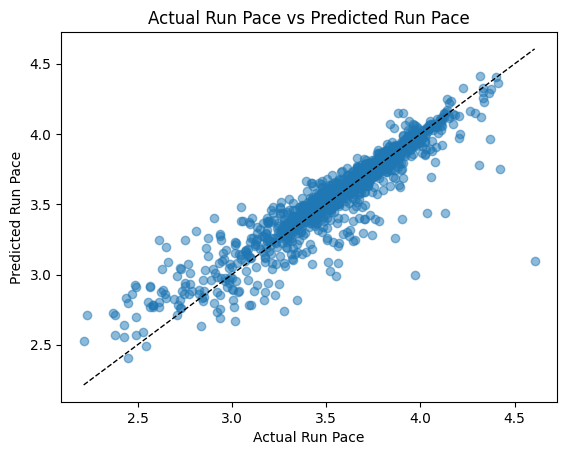

In [94]:
### Train/Evaluate the model on the the whole dataset (no split) ####

# Train the model on data_run (pace_model_eval)
pace_model = rf_model.fit(np.column_stack((data_run['act_hr_run'],data_run['act_altitude_run'],data_run['act_distance_run'],data_run['act_tss_run'],data_run['temperature'])), data_run['act_gap_run'])
# Make a prediction and store in the pace_yhat variable
pace_yhat = pace_model.predict(np.column_stack((data_run['act_hr_run'],data_run['act_altitude_run'],data_run['act_distance_run'],data_run['act_tss_run'],data_run['temperature'])))
# compute the rmse and mape
rmse = np.sqrt(mean_squared_error(data_run['act_gap_run'], pace_yhat))
mape = mean_absolute_percentage_error(data_run['act_gap_run'], pace_yhat)
# print the results
print('-------------------------------')
print('All Data (no split) - Run Pace')
print('-------------------------------')
print('Run Pace RMSE (all data): %.3f' % rmse)
print('Run Pace MAPE (all data): %.3f' % mape)

### Train the model on the 80% of the dataset and evaluate on the 20% of the dataset ####

# Train the model on data_run_train (pace_model_eval)
pace_model_eval = pace_model.fit(np.column_stack((data_run_train['act_hr_run'],data_run_train['act_altitude_run'],data_run_train['act_distance_run'],data_run_train['act_tss_run'],data_run_train['temperature'])), data_run_train['act_gap_run'])
# Make a prediction and store in the pace_yhat_eval variable
pace_yhat_eval = pace_model_eval.predict(np.column_stack((data_run_test['act_hr_run'],data_run_test['act_altitude_run'],data_run_test['act_distance_run'],data_run_test['act_tss_run'],data_run_test['temperature'])))
# compute the correlation, rmse and mape
rmse = np.sqrt(mean_squared_error(data_run_test['act_gap_run'], pace_yhat_eval))
mape = mean_absolute_percentage_error(data_run_test['act_gap_run'], pace_yhat_eval)
corr = np.corrcoef(data_run_test['act_gap_run'], pace_yhat_eval)
# print the results
print('---------------------------------')
print('80 Train/20 Test Split - Run Pace')
print('---------------------------------')
print('Run Pace Correlation (80/20 split): %.3f' % corr[0,1])
print('Run Pace RMSE (80/20 split): %.3f' % rmse)
print('Run Pace MAPE (80/20 split): %.3f' % mape)
# plot the results
fig, ax = plt.subplots()
plt.scatter(data_run_test['act_gap_run'], pace_yhat_eval,alpha=0.5)
ax.plot([min(data_run_test['act_gap_run']), max(data_run_test['act_gap_run'])], [min(data_run_test['act_gap_run']), max(data_run_test['act_gap_run'])], 'k--', lw=1)
plt.xlabel('Actual Run Pace')
plt.ylabel('Predicted Run Pace')
plt.title('Actual Run Pace vs Predicted Run Pace')
plt.show()

Fit the model to predict the run efficiency. Evaluate on all data and also 80/20 train test split.
Calculate and print the accuracy, and plot on a scatter plot.

---------------------------------------
All Data (no split) - Run Efficiency
-------------------------------------
Run EF RMSE (all data): 0.016
Run EF MAPE (all data): 0.034
---------------------------------------
80 Train/20 Test Split - Run Efficiency
---------------------------------------
Run EF Correlation (80/20 split): 0.991
Run EF RMSE (80/20 split): 0.271
Run EF MAPE (80/20 split): 0.429


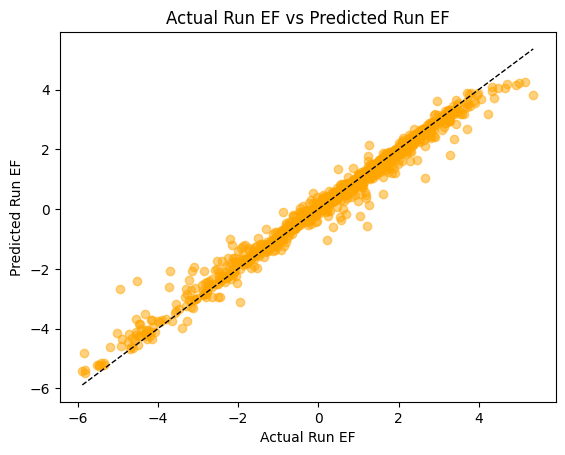

In [95]:
### Train/Evaluate the model on the the whole dataset (no split) ####

# Train the model on data_run (pace_model_eval)
ef_model = rf_model.fit(np.column_stack((data_run['act_hr_run'],data_run['act_altitude_run'],data_run['act_distance_run'],data_run['act_gap_run'],data_run['act_tss_run'],data_run['temperature'])), data_run['ef_run'])
ef_yhat = ef_model.predict(np.column_stack((data_run['act_hr_run'],data_run['act_altitude_run'],data_run['act_distance_run'],data_run['act_gap_run'],data_run['act_tss_run'],data_run['temperature'])))
# compute the rmse and mape
rmse = np.sqrt(mean_squared_error(data_run['ef_run'], ef_yhat))
mape = mean_absolute_percentage_error(data_run['ef_run'], ef_yhat)
# print the results
print('---------------------------------------')
print('All Data (no split) - Run Efficiency')
print('-------------------------------------')
print('Run EF RMSE (all data): %.3f' % rmse)
print('Run EF MAPE (all data): %.3f' % mape)

### Train the model on the 80% of the dataset and evaluate on the 20% of the dataset ####

# Train the model on data_run_train (ef_model_eval)
ef_model_eval = ef_model.fit(np.column_stack((data_run_train['act_hr_run'],data_run_train['act_altitude_run'],data_run_train['act_distance_run'],data_run_train['act_gap_run'],data_run_train['act_tss_run'],data_run_train['temperature'])), data_run_train['ef_run'])
# Make a prediction and store in the ef_yhat_eval variable
ef_yhat_eval = ef_model_eval.predict(np.column_stack((data_run_test['act_hr_run'],data_run_test['act_altitude_run'],data_run_test['act_distance_run'],data_run_test['act_gap_run'],data_run_test['act_tss_run'],data_run_test['temperature'])))
# compute the correlation, rmse and mape
rmse = np.sqrt(mean_squared_error(data_run_test['ef_run'], ef_yhat_eval))
mape = mean_absolute_percentage_error(data_run_test['ef_run'], ef_yhat_eval)
corr = np.corrcoef(data_run_test['ef_run'], ef_yhat_eval)
# print the results
print('---------------------------------------')
print('80 Train/20 Test Split - Run Efficiency')
print('---------------------------------------')
print('Run EF Correlation (80/20 split): %.3f' % corr[0,1])
print('Run EF RMSE (80/20 split): %.3f' % rmse)
print('Run EF MAPE (80/20 split): %.3f' % mape)
# plot the results
fig, ax = plt.subplots()
ax.scatter(data_run_test['ef_run'], ef_yhat_eval, color='orange', alpha=0.5)
ax.plot([min(data_run_test['ef_run']), max(data_run_test['ef_run'])], [min(data_run_test['ef_run']), max(data_run_test['ef_run'])], 'k--', lw=1)
plt.xlabel('Actual Run EF')
plt.ylabel('Predicted Run EF')
plt.title('Actual Run EF vs Predicted Run EF')
plt.show()

Plot on scatter plot act_hr_run on the bottom x axes and HRmax percentages on the top x axis.
Plot pace_yhat on the left y axes and the efficiency factor on the right y axis.
Plot lines of best fit for both ML models.
Plot vertical lines corresponding to Hight EF and Low EF groupings.

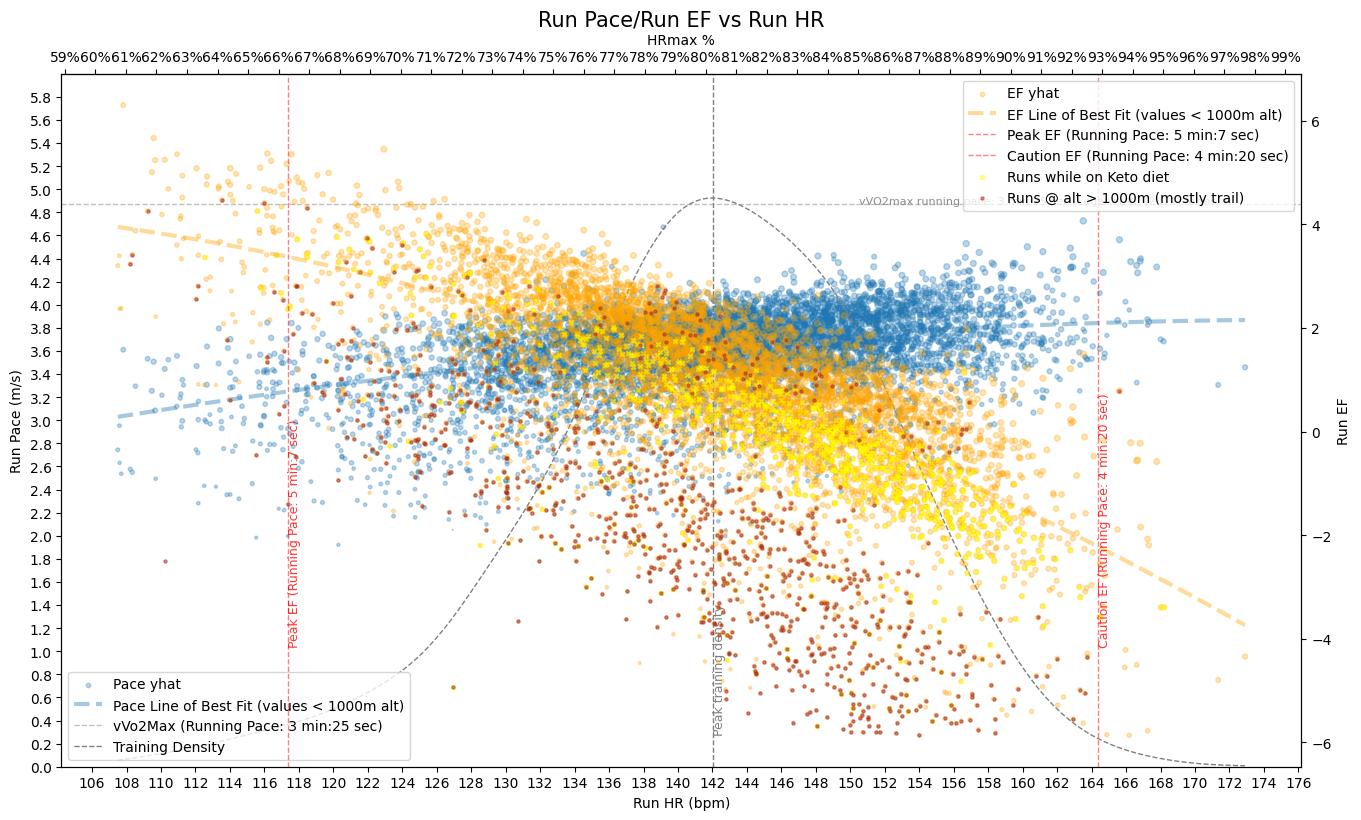

In [96]:
size = (data_run['act_distance_run'] - np.min(data_run['act_distance_run']))/(np.max(data_run['act_distance_run']) - np.min(data_run['act_distance_run']))*20
fig, ax1 = plt.subplots(figsize=(16, 9))
ax1.set_ylim(0,6)
ax1.set_xticks(np.arange(100, 180, 2))
ax1.set_yticks(np.arange(0, 6, 0.2))
ax1.scatter(data_run['act_hr_run'], pace_yhat,s=size, alpha=0.3)

#set secondary x axis with HRmax percentage
def hr2perc(x):
    return x/HRmax*100
def perc2hr(x):
    return x*HRmax/100
secax = ax1.secondary_xaxis('top', functions=(hr2perc,perc2hr))
secax.set_xlabel('HRmax %')
#set ticks on secondary x axis
secax.set_xticks(np.arange(0, 100, 1))
#set % sign too all values on secondary x axis
secax.set_xticklabels(['{}%'.format(x) for x in secax.get_xticks().tolist()])
#set title
ax1.set_title('Run Pace/Run EF vs Run HR', fontsize=15)

#Plot line of best fit. Exclude values with altitude over 1000m
z = np.polyfit(data_run['act_hr_run'][data_run['act_altitude_run']<1000],pace_yhat[data_run['act_altitude_run']<1000], 2)
p_pace = np.poly1d(z)
ax1.plot(data_run['act_hr_run'],p_pace(data_run['act_hr_run']),linewidth=3,alpha=0.4,linestyle='--')

#plot vvo2max in m/s horizontal line
ax1.axhline(y=1/(vvo2max_run/1000), linewidth=1, color='grey', alpha=0.5, linestyle='--')
#add text to the line
# convert the GAP fom m/s to min:sec per km
pace = 1000/((1/(vvo2max_run/1000))*60)
leftover = pace % 1
minutes = pace-leftover
seconds = leftover*60
vvo2max_running_pace = str(int(minutes)) + ' min:' + str(int(seconds)) + ' sec'
ax1.text(150.5, 1/(vvo2max_run/1000), 'vVO2max running pace: '+vvo2max_running_pace+' (Leger et al. (2012) formula)', color='grey', alpha=0.9, fontsize=8)

# compute and plot the training density curve 
density = gaussian_kde(data_run['act_hr_run'])
xs = np.linspace(min(data_run['act_hr_run']), max(data_run['act_hr_run']), 200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax1.plot(xs,density(xs)*120,linewidth=1, color='grey', alpha=1, linestyle='--')
# mark the highest density with a vertical line
max_density_index = np.argmax(density(xs))
ax1.axvline(x=xs[max_density_index], linewidth=1,color='grey', alpha=1, linestyle='--')
#add text to the line
ax1.text(xs[max_density_index], 0.3, 'Peak training density', rotation=90, color='grey', alpha=1, fontsize=9)

#set labels and title
ax1.set_xlabel('Run HR (bpm)')
ax1.set_ylabel('Run Pace (m/s)')

#legend
ax1.legend(['Pace yhat','Pace Line of Best Fit (values < 1000m alt)','vVo2Max (Running Pace: '+vvo2max_running_pace+')','Training Density'],loc='lower left')

# set the second y-axis
ax2 = ax1.twinx()
ax2.scatter(data_run['act_hr_run'], ef_yhat, s=size, c='orange', alpha=0.3)

# for each yhat point take 'n' preceding values and 'n' following values and compute the average. Store the averages in a list. 
# find an index of the point with the highest  average and mark with a vertical line
# set window size to 4% of all samples
window_size = int(len(data_run['ef_run'])*0.04)
window_size_half = int(window_size/2)
yhat_avg = []
for i in range(0, len(ef_yhat)):
    if i < window_size_half:
        yhat_avg.append(np.mean(ef_yhat[0:i+window_size_half]))
    elif i > len(ef_yhat)-window_size_half:
        yhat_avg.append(np.mean(ef_yhat[i-window_size_half:]))
    else:
        yhat_avg.append(np.mean(ef_yhat[i-window_size_half:i+window_size_half]))

# find the index of the highest average and store in peak_ef variable
max_yhat_avg_index = np.argmax(yhat_avg)
peak_ef = yhat_avg[max_yhat_avg_index]

#Plot line of best fit. Exclude values with altitude over 1000m.
#This gives a more accurate estimate of the Peak EF, however indicates that the GAP/Altitude correction factor might need to be adjusted.
z = np.polyfit(data_run['act_hr_run'][data_run['act_altitude_run']<1000],ef_yhat[data_run['act_altitude_run']<1000], 2)
p_ef = np.poly1d(z)
ax2.plot(data_run['act_hr_run'],p_ef(data_run['act_hr_run']),c='orange',linewidth=3,alpha=0.4,linestyle='--')

# draw a vertical line where the value of p_ef equals peak_ef
x = np.linspace(min(data_run['act_hr_run']), max(data_run['act_hr_run']), 200)
ax2.axvline(x=x[np.argmin(np.abs(p_ef(x)-peak_ef))], linewidth=1,color='red', alpha=0.5, linestyle='--')

#print the pace at the intersect of peak ef and pace line of best fit
pace_at_peak_ef = p_pace(x[np.argmin(np.abs(p_ef(x)-peak_ef))])
# convert the GAP fom m/s to min:sec per km
pace = 1000/(pace_at_peak_ef*60)
leftover = pace % 1
minutes = pace-leftover
seconds = leftover*60
peak_ef_running_pace = str(int(minutes)) + ' min:' + str(int(seconds)) + ' sec'
#add text to the line
ax2.text(x[np.argmin(np.abs(p_ef(x)-peak_ef))], -4.1, 'Peak EF (Running Pace: '+peak_ef_running_pace+')', rotation=90, color='red', alpha=0.8, fontsize=9)

# find the index of the lowest average and store in caution_ef variable
min_yhat_avg_index = np.argmin(yhat_avg)
caution_ef = yhat_avg[min_yhat_avg_index]
# draw a vertical line where the value of p_ef equals caution_ef
x = np.linspace(min(data_run['act_hr_run']), max(data_run['act_hr_run']), 200)
ax2.axvline(x=x[np.argmin(np.abs(p_ef(x)-caution_ef))], linewidth=1,color='red', alpha=0.5, linestyle='--')

#print the pace at the intersect of peak ef and pace line of best fit
pace_at_caution_ef = p_pace(x[np.argmin(np.abs(p_ef(x)-caution_ef))])
# convert the GAP fom m/s to min:sec per km
pace = 1000/(pace_at_caution_ef*60)
leftover = pace % 1
minutes = pace-leftover
seconds = leftover*60
caution_ef_running_pace = str(int(minutes)) + ' min:' + str(int(seconds)) + ' sec'
#add text to the line
ax2.text(x[np.argmin(np.abs(p_ef(x)-caution_ef))], -4.1, 'Caution EF (Running Pace: '+caution_ef_running_pace+')', rotation=90, color='red', alpha=0.8, fontsize=9)

#mark the values between 2021-07-21 and 2022-04-09 with a yellow "+". (Runs during Keto diet)
ax2.scatter(data_run['act_hr_run'][(data_run['time_interval']>'2021-07-21') & (data_run['time_interval']<'2022-04-09')], ef_yhat[(data_run['time_interval']>'2021-07-21') & (data_run['time_interval']<'2022-04-09')],c='yellow',marker='x',s=10, alpha=0.6)

#mark the values with the altitude > 1000m with a red dot
ax2.scatter(data_run['act_hr_run'][data_run['act_altitude_run']>1000], ef_yhat[data_run['act_altitude_run']>1000],c='brown',s=5, alpha=0.5)

#set labels
ax2.set_ylabel('Run EF')

#legend
ax2.legend(['EF yhat','EF Line of Best Fit (values < 1000m alt)','Peak EF (Running Pace: '+peak_ef_running_pace+')','Caution EF (Running Pace: '+caution_ef_running_pace+')','Runs while on Keto diet','Runs @ alt > 1000m (mostly trail)'],loc='upper right')

#show the plot
plt.show()